In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# direction = 0: steepest descent, direction = 1: Newton, direction = 2: BFGS
def backtracking_line_search(direction, x, pot, grad, hess, m=20, verbose=False):
    f = pot(x)
    g = grad(x)
    norm_g = np.linalg.norm(g)
    print(f'Initially, f = {f}, ||grad f|| = {norm_g}')

    fvals = [f]
    ngvals = [norm_g]
    avals = []
    xvals = [x]

    iter = 1
    while (norm_g > tol and iter < iter_max):
        # first choose search direction
        if direction == 0: # steepest descent
            p = -g
            dir = 'SD'
        elif direction == 1: # Newton
            H = hess(x)
            p = np.linalg.solve(H, -g)
            spd = np.all(np.linalg.eigvals(H) > 0)
            if spd: # if H is SPD, use Newton's direction
                p = np.linalg.solve(H, -g)
                dir = 'Newton'
            else: # use steepest descent direction otherwise
                p = -g
                dir = 'SD'
        elif direction == 2: # BFGS
            if iter % m == 1: # reset B to the identity every mth iteration
                B = np.eye(len(x))
            else:
                s = x - x_old
                y = g - g_old
                if np.dot(y, s) > 1e-15:
                    B -= (B @ np.outer(s, s) @ B) / np.inner(s, B @ s) - np.outer(y, y) / np.inner(y, s)
                else:
                    break
            x_old = x
            g_old = g
            p = np.linalg.solve(B, -g)
            dir = 'BFGS'
        else:
            print('direction is out of range')
            break

        # normalize the search direction if its length greater than 1
        norm_p = np.linalg.norm(p)
        if (norm_p > 1):
            p /= norm_p

        # then do backtracking line search along the direction p
        a = 1 # initial step length
        f_temp = pot(x + a * p)
        cpg = c * np.dot(p, g)
        while (f_temp > f + a * cpg): # check Wolfe's condition 1
            a *= rho
            if a < 1e-14:
                print('line search failed')
                iter = iter_max - 1
                break
            f_temp = pot(x + a * p)

        # finally update values before finishing iteration
        x = x + a * p
        f = pot(x)
        g = grad(x)
        norm_g = np.linalg.norm(g)
        fvals.append(f)
        ngvals.append(norm_g)
        avals.append(a)
        xvals.append(x)

        if verbose:
            print(f'iter {iter}: dir = {dir}, f = {f:.6f}, ||grad f|| = {norm_g:.6e}, step length = {a:.3e}')
        iter += 1

    print(f'Result: f = {f:.10f}, ||grad f|| = {norm_g:.6e}')
    xvals = np.array(xvals)
    return xvals, fvals, ngvals, avals

### 3. Minimizing Lennard-Jones Pair Potentials via Line Search 

In [3]:
# Four local minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid
# f2 = -15.93504306 Capped octahedron
# f3 = -15.59321094 Tricapped tetrahedron
# f4 = -15.53306005 Bicapped trigonal bipyramid

Na = 7 # number of atoms
rstar = 2**(1 / 6) # minimizer of Lennard-Jones pair potential r^(-12) - r^(-6)
tol = 1e-9 # stop iterations when ||grad f|| < tol
iter_max = 1000 # maximal number of iterations

# Parameters for backtracking line search
c = 0.1
rho = 0.9

# Options: model = 0, 1, 2, 3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.
model = 0

In [4]:
def lf_minimize(direction, model):
  xyz = initial_configuration(model, Na, rstar)
  x = remove_rotations_translations(xyz)
  xvals, fvals, ngvals, _ = backtracking_line_search(2, x, LJpot, LJgrad, LJhess)

  # visualize the final configuration and plot graphs
  drawconf(LJvector2array(xvals[-1]), 0.5 * rstar)

  fig, axs = plt.subplots(nrows=3)
  fig.tight_layout()

  axs[0].plot(range(len(fvals)), fvals)
  axs[0].set_ylabel('$f$')

  axs[1].plot(range(len(ngvals)), ngvals)
  axs[1].set_xlabel('Iteration')
  axs[1].set_ylabel('$|| \operatorname{grad} f ||$')
  axs[1].set_yscale('log')

  evals = np.sort(np.linalg.eigvals(LJhess(xvals[-1])))
  axs[2].scatter(range(len(evals)), evals)
  axs[2].set_xlabel('Index')
  axs[2].set_ylabel('Eigenvalues of $H$')
  if (evals[0] > 0):
      axs[2].set_yscale('log')
  plt.show()

Initially, f = -11.517662869490488, ||grad f|| = 16.468632904952266
Result: f = -16.5053841680, ||grad f|| = 8.187555e-10


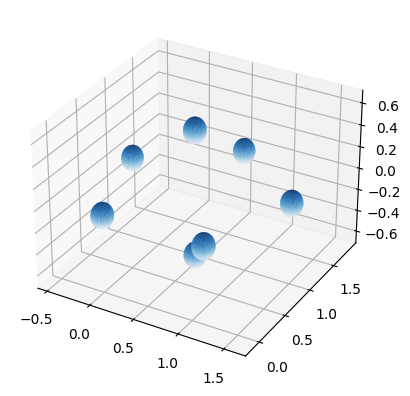

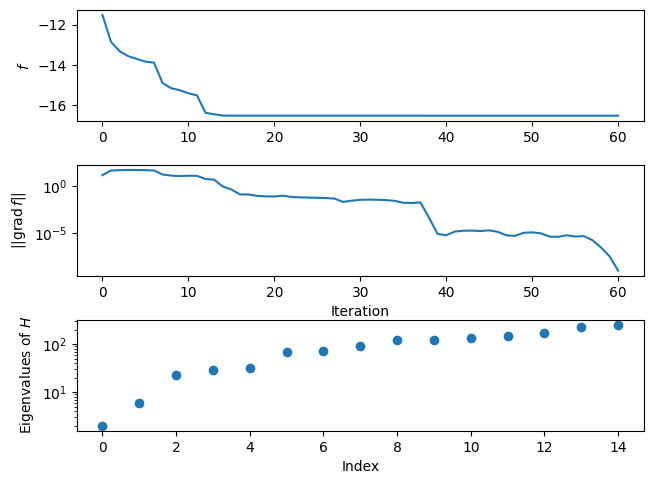

Initially, f = -15.921231995884773, ||grad f|| = 2.1196800775302633
Result: f = -15.9350430605, ||grad f|| = 4.785875e-07


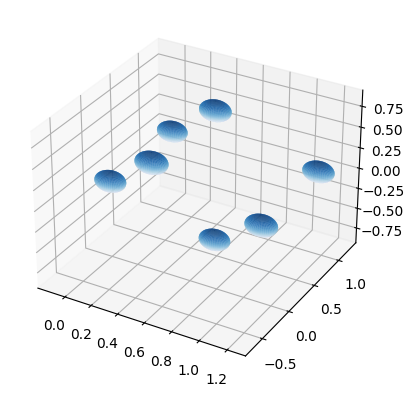

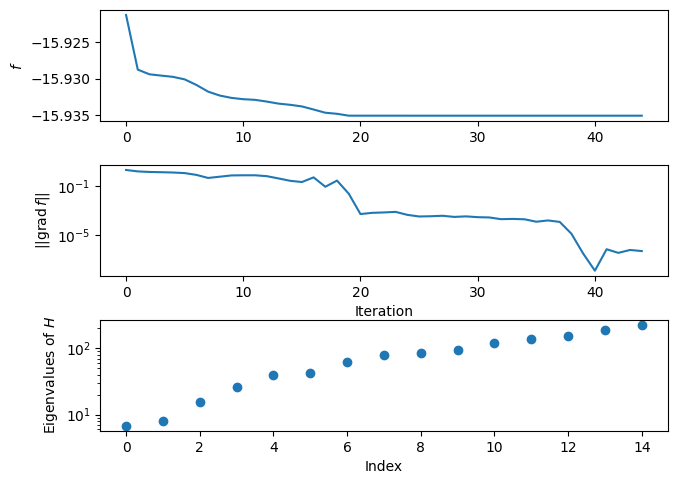

Initially, f = -15.581469160072078, ||grad f|| = 1.4608366392938117
Result: f = -15.5932109382, ||grad f|| = 5.416143e-07


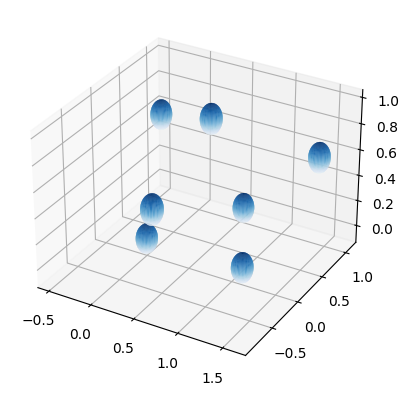

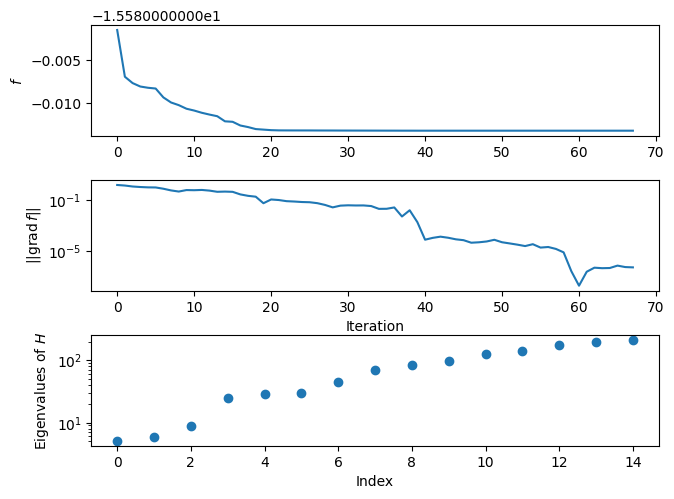

Initially, f = -15.522210169999571, ||grad f|| = 1.2854375635525521
Result: f = -15.5330600546, ||grad f|| = 2.056587e-07


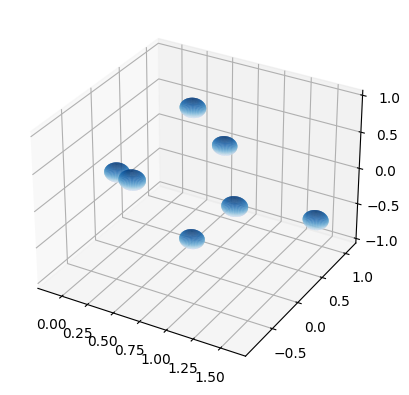

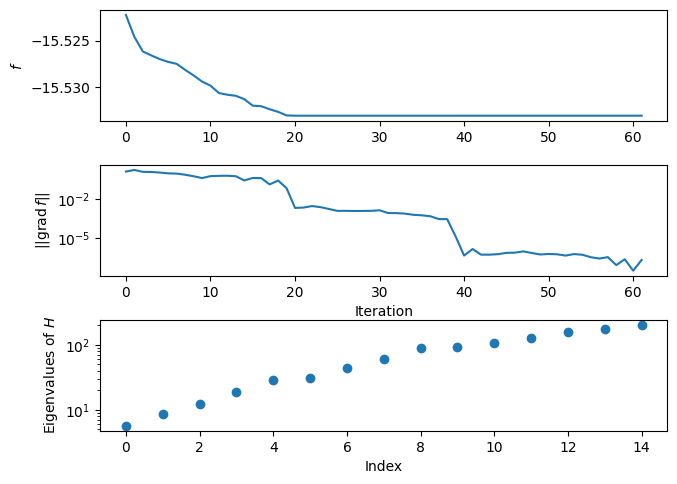

In [5]:
# try initial conditions for each of the minima...
for model in [1, 2, 3, 4]:
  lf_minimize(2, model)

# ...plus ten random initial conditions
# for _ in range(10):
#   lf_minimize(2, 0)

### 4. Rosenbrock Function

In [6]:
def rosen_minimize(direction, x):
  # define the potential function, gradient, and hessian
  def rosen_pot(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

  def rosen_grad(x):
    return np.array([-400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0]), 200 * (x[1] - x[0]**2)])

  def rosen_hess(x):
    return np.array([[-400 * (x[1] - x[0]**2) + 800 * x[0]**2 + 2, -400 * x[0]],
                    [-400 * x[0], 200]])

  # perform the backtracking line search
  x_vals, _, _, a_vals = backtracking_line_search(direction, x, rosen_pot, rosen_grad, rosen_hess)
  print(x_vals[-1])

  # plot the desired graphs
  dir_strings = ['Steepest Descent', 'Newton', 'BFGS']
  plt.suptitle(f'{dir_strings[direction]} with $x_0 = {x}$')

  ax1 = plt.subplot(221)
  ax2 = plt.subplot(223)
  ax3 = plt.subplot(122)

  ax1.plot(range(len(a_vals)), a_vals)
  ax1.set_ylabel('$\\alpha_k$')

  ax2.plot(range(len(x_vals)), np.linalg.norm(x_vals - [1, 1], axis=1))
  ax2.set_ylabel('$|| (x_k, y_k) - (x^*, y^*) ||$')
  ax2.set_yscale('log')
  ax2.set_xlabel('$k$')

  # ax3.contour(TODO)
  plt.show()

Initially, f = 5.8, ||grad f|| = 125.16932531574977
Result: f = 0.0034487887, ||grad f|| = 1.173181e-01
[1.05855161 1.12098426]


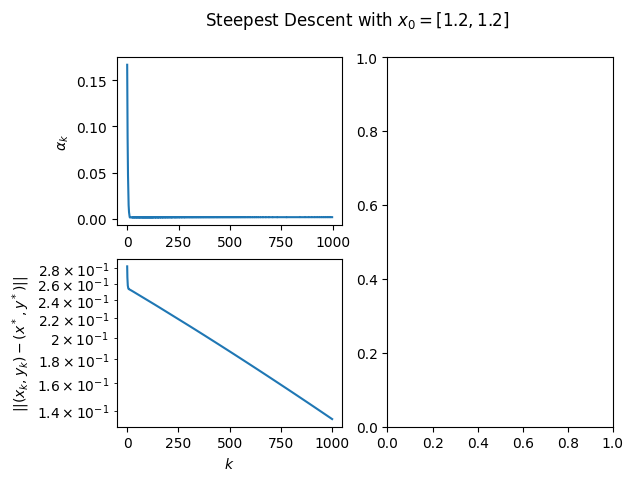

Initially, f = 24.199999999999996, ||grad f|| = 232.86768775422664
Result: f = 0.0161138706, ||grad f|| = 3.427853e-01
[0.87308316 0.76251885]


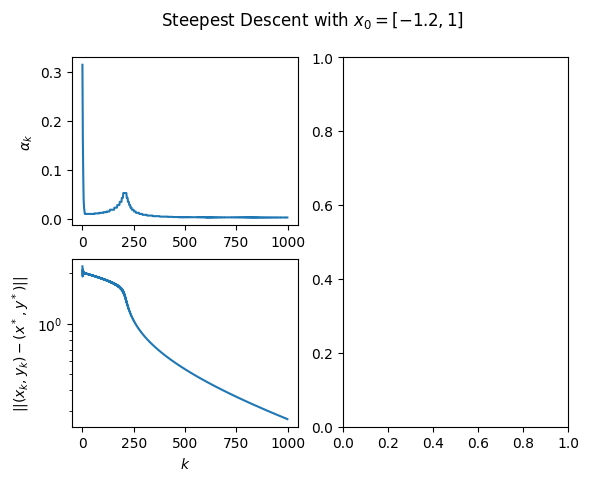

Initially, f = 5.8, ||grad f|| = 125.16932531574977
Result: f = 0.0000000000, ||grad f|| = 2.056839e-10
[1. 1.]


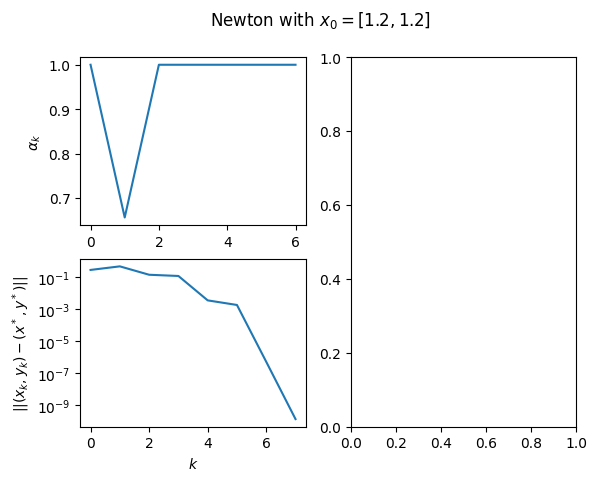

Initially, f = 24.199999999999996, ||grad f|| = 232.86768775422664
Result: f = 0.0000000000, ||grad f|| = 1.092910e-10
[1. 1.]


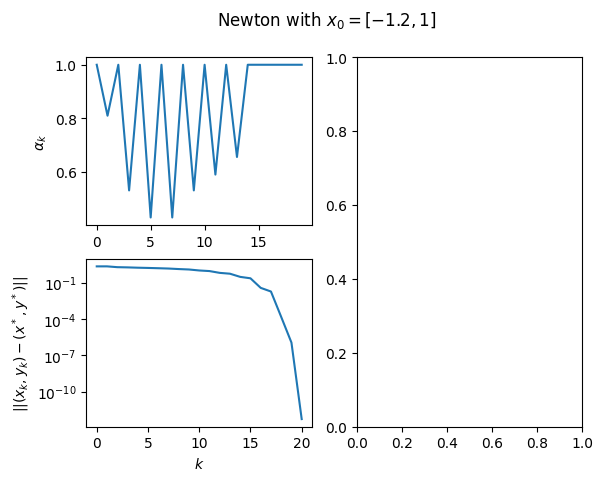

Initially, f = 5.8, ||grad f|| = 125.16932531574977
Result: f = 0.0000000000, ||grad f|| = 9.558918e-12
[1. 1.]


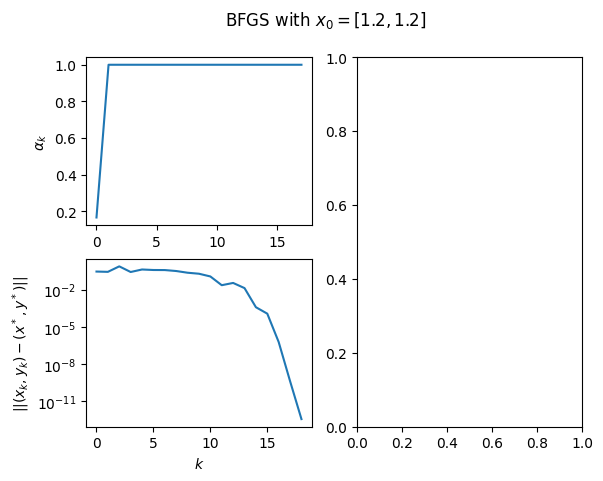

Initially, f = 24.199999999999996, ||grad f|| = 232.86768775422664
Result: f = 0.0000000000, ||grad f|| = 5.328927e-13
[1. 1.]


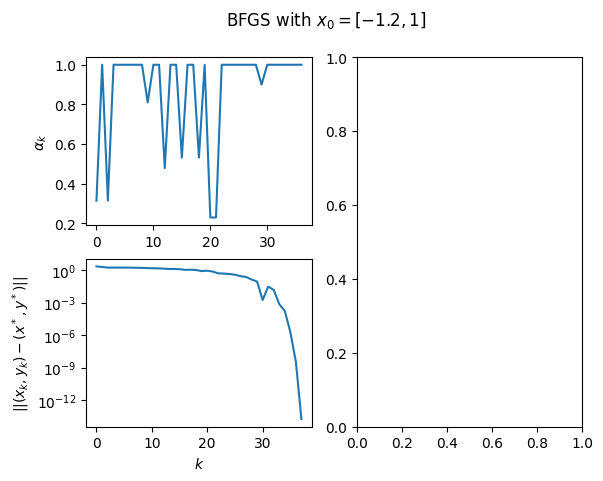

In [7]:
for direction in [0, 1, 2]:
  for x in [[1.2, 1.2], [-1.2, 1]]:
    rosen_minimize(direction, x)